In [1]:
import sys
import numpy as np
import spectral as sp
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
from unmixing_algorithms import *
from extinctions import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

### Load endmember spectra

In [63]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_ray = (band_centers/500)**(-4)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")


extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])

M = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat"]
M_smooth = smooth_spectral(M.T,5).T

M_ones = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones)).T
endmember_labels_ones = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones"]

M_ones_scatter = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray)).T
endmember_labels_ones_scatter = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones", "scatter"]

M_scatter = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_ray)).T
endmember_labels_scatter = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "scatter"]
M_scatter_smooth = smooth_spectral(M_scatter.T,5).T

### Load Hyperspectral image

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


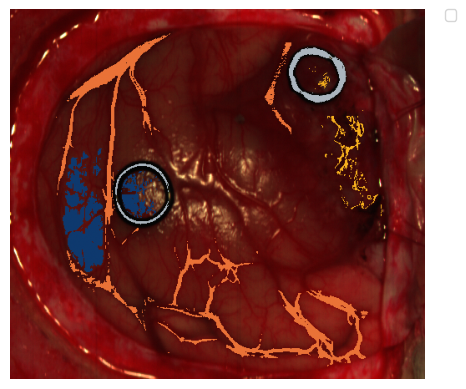

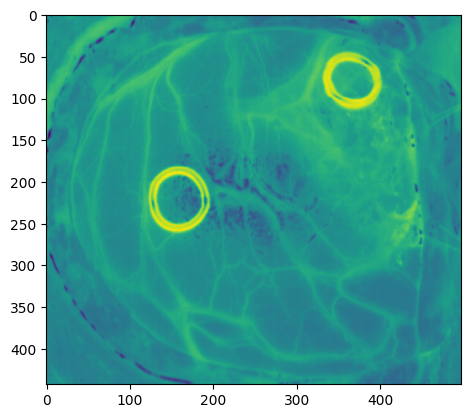

In [108]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)


img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)

img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

plt.figure()
img_sum = np.linalg.norm(absorbance, axis=-1, ord=1)
plt.imshow(img_sum)

### Plotting functions

In [107]:
def check_fit_mie(b_mie_img, P, abs):
    np.random.seed(42)
    # plot 40 random pixel spectra as well as the fit
    m, l, k = abs.shape
    n = M.shape[1]
    fig, axs = plt.subplots(8, 5, figsize=(15,20))
    for i in range(40):
        idx_1 = np.random.randint(0, m)
        idx_2 = np.random.randint(0, l)
        axs[i//5,i%5].plot(band_centers, abs[idx_1,idx_2,:], label="abs", color="r", linewidth=2)

        scatter_mie = (band_centers/500)**(-b_mie_img[idx_1,idx_2])
        scatter_mie_proj = P @ scatter_mie
        lam = np.dot(scatter_mie_proj, abs[idx_1,idx_2,:]) / np.linalg.norm(scatter_mie_proj)**2

        axs[i//5,i%5].plot(band_centers, lam * scatter_mie_proj, label="fit", color="k", linewidth=2)

    # place legend centered below the subplots
    axs[7,2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5)
    return fig, axs

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_concentrations(c, endmember_labels=None, figsize=(15,9)):
    N = c.shape[2]
    if N < 5:
        fig, axs = plt.subplots(1, N, figsize=figsize)
        for i in range(N):
            axs[i].imshow(c[:,:,i], cmap=tum_cmap)
            axs[i].set_title(endmember_labels[i])
            axs[i].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i].images[0], cax=cax)
    else:
        fig, axs = plt.subplots(int(np.ceil(N/5)), 5, figsize=figsize)
        for i in range(N):
            axs[i//5,i%5].imshow(c[:,:,i], cmap=tum_cmap)
            axs[i//5,i%5].set_title(endmember_labels[i])
            axs[i//5,i%5].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i//5,i%5])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i//5,i%5].images[0], cax=cax)
    _ = plt.tight_layout()
    return fig, axs

def plot_error_img(err):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    err_img = plt.imshow(np.linalg.norm(err, axis=2))
    print(np.linalg.norm(err.flatten()))
    fig.colorbar(err_img, ax=ax)
    return fig, ax

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_pca(spectr, gt_map, class_labels):

    np.random.seed(0)
    N = spectr[np.where(gt_map.asarray()[:,:,0] == 1)]
    T = spectr[np.where(gt_map.asarray()[:,:,0] == 2)]
    B = spectr[np.where(gt_map.asarray()[:,:,0] == 3)]

    # select random samples from each class such that the number of samples is equal to the smallest class or max_samples
    nsamples = min(N.shape[0], T.shape[0], B.shape[0])

    idx_N = np.random.choice(N.shape[0], nsamples, replace=False)
    N = N[idx_N]
    idx_T = np.random.choice(T.shape[0], nsamples, replace=False)
    T = T[idx_T]
    idx_B = np.random.choice(B.shape[0], nsamples, replace=False)
    B = B[idx_B]

    NTB = np.concatenate((N, T, B))

    pca = PCA(n_components=2)
    NTB_pca = pca.fit_transform(NTB)


    tsne = TSNE(n_components=2)
    NTB_tsne = tsne.fit_transform(NTB)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    Y = np.repeat([1, 2, 3], nsamples)
    class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]
    for i in range(1,4):
        axs[0].scatter(NTB_tsne[Y==i, 0], NTB_tsne[Y==i, 1], label=class_labels[i], color=class_colors[i])
        axs[1].scatter(NTB_pca[Y==i, 0], NTB_pca[Y==i, 1], label=class_labels[i], color=class_colors[i])
    axs[0].set_title('t-SNE')
    axs[1].set_title('PCA')
    axs[0].legend()

### Scattering power optimization functions

scipy LS

In [8]:
def f(b_mie, *args):
    P, abs_proj = args
    scatter_mie = (band_centers/500)**(-b_mie)
    scatter_mie_proj = P @ scatter_mie
    abs_proj = abs_proj / np.linalg.norm(abs_proj) + 1e-8
    similarity = np.dot(scatter_mie_proj, abs_proj) / (np.linalg.norm(scatter_mie_proj) + 1e-8)
    # |a-b|^2 = a^Ta + b^Tb - 2a^Tb = 2 - 2a^Tb = 2 - 2*similarity for normalized vectors a and b
    d = 2 - 2*similarity
    return d

def d_f(b_mie, *args):
    P, abs_proj = args
    scatter_mie = (band_centers/500)**(-b_mie)
    scatter_mie_norm = np.linalg.norm(scatter_mie)
    abs_proj = abs_proj / np.linalg.norm(abs_proj) + 1e-8
    d_d = -2
    d_similarity = abs_proj/scatter_mie_norm - scatter_mie * np.dot(abs_proj, scatter_mie) / (scatter_mie_norm**3)
    d_scatter_mie_proj = P
    d_scatter_mie = - np.log(band_centers/500) * scatter_mie
    return d_d * d_similarity.T @ d_scatter_mie_proj @ d_scatter_mie

def optimize_scatter_ls(P, abs_proj):
    result = np.zeros_like(abs_proj[:,:,0])
    for i in tqdm(range(abs_proj.shape[0])):
        for j in range(abs_proj.shape[1]):
            x0 = 0.6
            bounds = (0, 4)
            args = (P, abs_proj[i, j, :])
            result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
    return result       

gradient descent

100%|██████████| 200/200 [09:09<00:00,  2.75s/it]


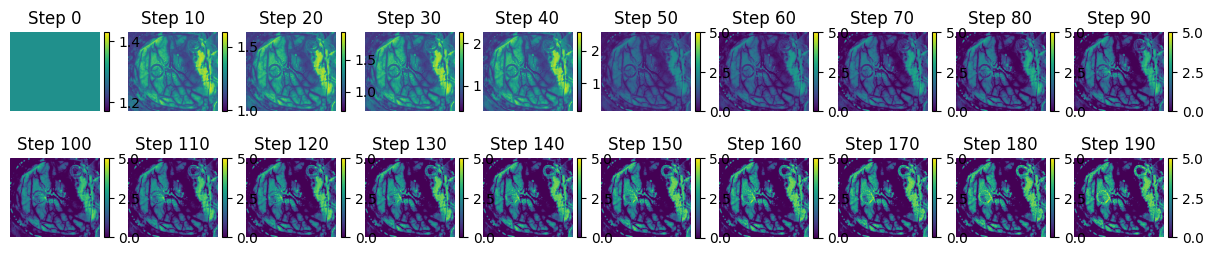

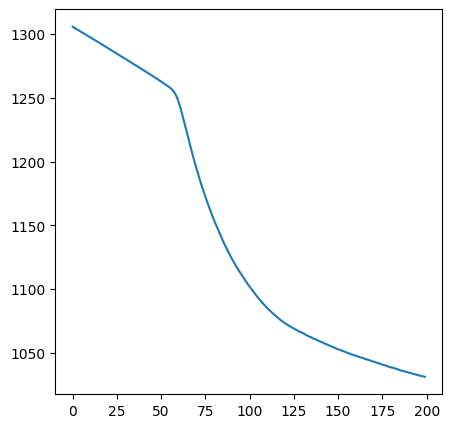

In [31]:
abs_proj, _ = project_absorbance(absorbance, M_ones_scatter.T, M_ones_scatter.T)
P = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)

def f(b_mie, *args):
    P, abs_proj, band_centers = args

    n = b_mie.shape[0]
    k = band_centers.shape[0]
    band_centers = band_centers.repeat(n, 1)
    b_mie = b_mie.repeat(k, 1).T
    
    scatter_mie = torch.pow(band_centers/500, -b_mie)
    scatter_mie_proj = torch.einsum("ij,...j->...i", P.double(), scatter_mie.double())
    abs_proj = abs_proj / (torch.norm(abs_proj, dim=1, keepdim=True) + 1e-12)
    scatter_mie_proj = scatter_mie_proj / (torch.norm(scatter_mie_proj, dim=1, keepdim=True) + 1e-12)
    similarity = torch.einsum("...i,...i->...", scatter_mie_proj.double(), abs_proj.double())
    d = 2 - 2*similarity
    return d

def d_f(b_mie, *args):
    eps = 1e-8
    d1 = f(b_mie + eps, *args)
    d2 = f(b_mie - eps, *args)
    return (d1 - d2) / (2*eps)

def gradient_descent(b_mie, *args, steps=200):
    fig, axs = plt.subplots(steps//100,10,figsize=(15,3))
    error = np.zeros(steps)

    for i in tqdm(range(steps)):
        grad = d_f(b_mie, *args)
        b_mie = b_mie - 0.1 * grad
        b_mie[b_mie < 0] = 0
        b_mie[b_mie > 5] = 5

        error[i] = torch.norm(f(b_mie, *args)).item()

        if i%10 == 0:
            ax = axs[i//100, (i%100)//10]
            ax.imshow(b_mie.reshape(abs_proj[:,:,0].shape))
            ax.set_title(f"Step {i}")
            ax.axis("off")
            # add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ax.images[0], cax=cax)

    plt.figure(figsize=(5,5))
    plt.plot(error)

    return b_mie

x0 = 1.3 * torch.from_numpy(np.ones_like(abs_proj[:,:,0]).flatten())
bounds = (torch.zeros_like(x0), 10*torch.ones_like(x0))
abs_flat = abs_proj.reshape(-1,abs_proj.shape[-1])
args = (torch.from_numpy(P), torch.from_numpy(abs_flat), torch.from_numpy(band_centers))

b_mie_img = gradient_descent(x0, *args, steps=200).reshape(abs_proj[:,:,0].shape).numpy()

Mie scattering

In [9]:
# abs_proj_ones_scatter, _ = project_absorbance(absorbance, M_ones_scatter.T, M_ones_scatter.T)
# P_ones_scatter = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)
# b_mie_img = optimize_scatter_ls(P_ones_scatter, abs_proj_ones_scatter)

abs_proj_scatter, _ = project_absorbance(absorbance, M_scatter_smooth.T, M_scatter_smooth.T)
P_scatter = np.eye(M_scatter_smooth.shape[0]) - M_scatter_smooth @ np.linalg.pinv(M_scatter_smooth)
b_mie_img = optimize_scatter_ls(P_scatter, abs_proj_scatter)

  0%|          | 0/443 [00:00<?, ?it/s]/tmp/ipykernel_3136643/92753090.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
100%|██████████| 443/443 [22:44<00:00,  3.08s/it]


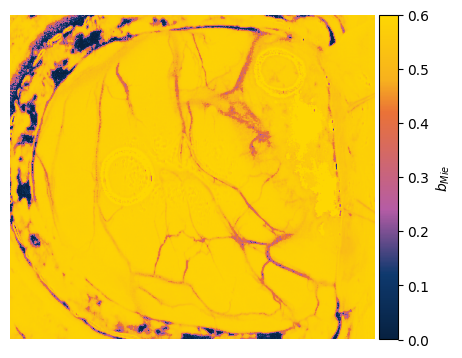

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(b_mie_img, cmap=tum_cmap)
ax.axis("off")
# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(ax.images[0], cax=cax)
cbar.set_label("$b_{Mie}$")

Simple Scattering

In [6]:
# abs_proj_ones, _ = project_absorbance(absorbance, M_ones.T, M_ones.T)
# P_ones = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)
# b_simple_img = optimize_scatter_ls(P_ones, abs_proj_ones)

abs_proj, _ = project_absorbance(absorbance, M_smooth.T, M_smooth.T)
P = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)
b_simple_img = optimize_scatter_ls(P, abs_proj)

  0%|          | 0/443 [00:00<?, ?it/s]/tmp/ipykernel_3136643/86588988.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i,j] = scipy.optimize.least_squares(f, x0=x0, args=args, bounds=bounds, jac=d_f).x
100%|██████████| 443/443 [12:15<00:00,  1.66s/it]


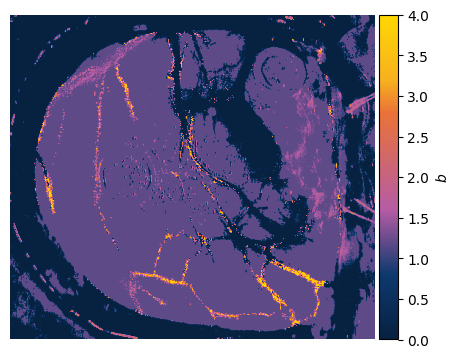

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(b_simple_img, cmap=tum_cmap)
ax.axis("off")
# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(ax.images[0], cax=cax)
cbar.set_label("$b$")

In [11]:
# save b_mie_img and b_simple_img as txt files
np.savetxt("b_mie_img.txt", b_mie_img)
np.savetxt("b_simple_img.txt", b_simple_img)

# load b_mie_img and b_simple_img from txt files
# b_mie_img = np.loadtxt("b_mie_img.txt")
# b_simple_img = np.loadtxt("b_simple_img.txt")

### Spectral unmixing

##### Cytochrome c oxibase

Removing Rayleigh scattering

100%|██████████| 443/443 [00:03<00:00, 116.11it/s]


466.59967453177416


(<Figure size 300x300 with 2 Axes>, <Axes: >)

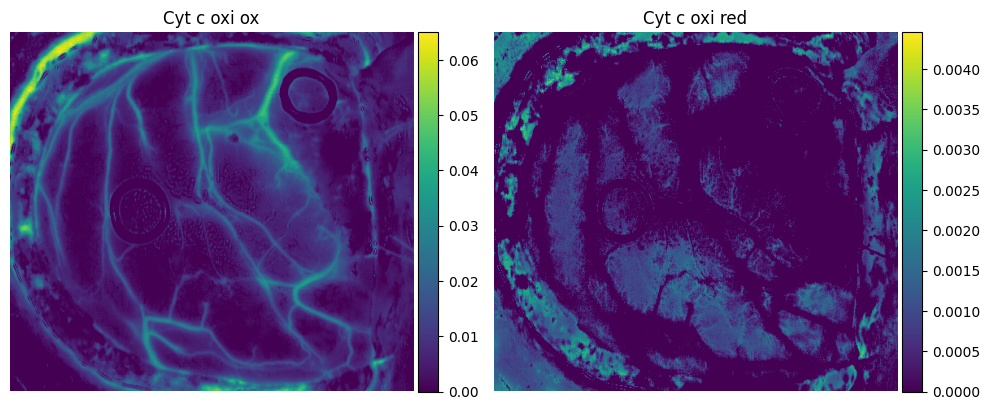

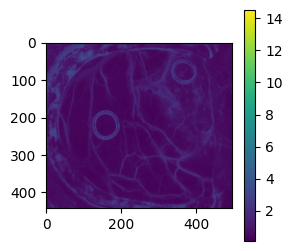

In [25]:
endmembers_proj_cyt_oxi = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones, scatter_ray))
endmembers_unmix_cyt_oxi = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_cyt_oxi_proj, endmembers_unmix_cyt_oxi_proj = project_absorbance(absorbance, endmembers_proj_cyt_oxi, endmembers_unmix_cyt_oxi, device="cuda")

M = endmembers_unmix_cyt_oxi_proj.T
c_cyt_oxi, err_cyt_oxi = unmix_LS_nonnegative(M, absorbance_cyt_oxi_proj)

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c_cyt_oxi, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_oxi)

Removing Rayleigh and Mie scattering

  2%|▏         | 8/443 [00:03<03:10,  2.29it/s]

100%|██████████| 443/443 [03:16<00:00,  2.25it/s]


423.0489


(<Figure size 300x300 with 2 Axes>, <Axes: >)

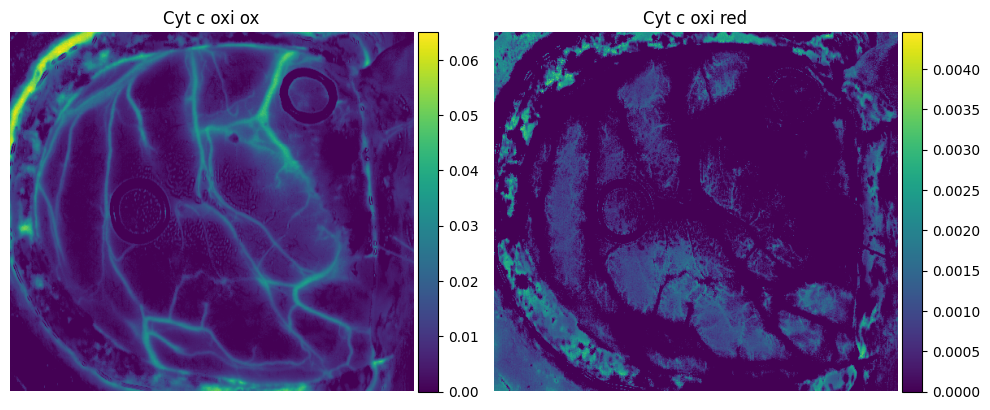

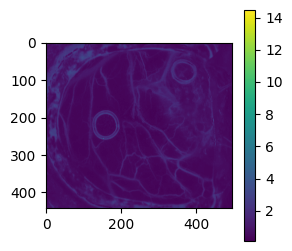

In [24]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones, scatter_ray))

endmembers_unmix = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)
for i in tqdm(range(b_mie_img.shape[0])):
    for j in range(b_mie_img.shape[1]):
        scatter_mie = (band_centers/500)**(-b_mie_img[i,j])
        scatter_mie_proj = P @ scatter_mie
        P_mie = np.eye(M_ones_scatter.shape[0]) - np.outer(scatter_mie_proj, scatter_mie_proj) / np.linalg.norm(scatter_mie_proj)**2
        absorbance_proj[i,j,:] = P_mie @ absorbance_proj[i,j,:]
        M_pixel = P_mie @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

# check_fit(c, M, absorbance_proj, endmember_labels)

Removing simplified scattering

100%|██████████| 443/443 [03:23<00:00,  2.17it/s]


448.82568


(<Figure size 300x300 with 2 Axes>, <Axes: >)

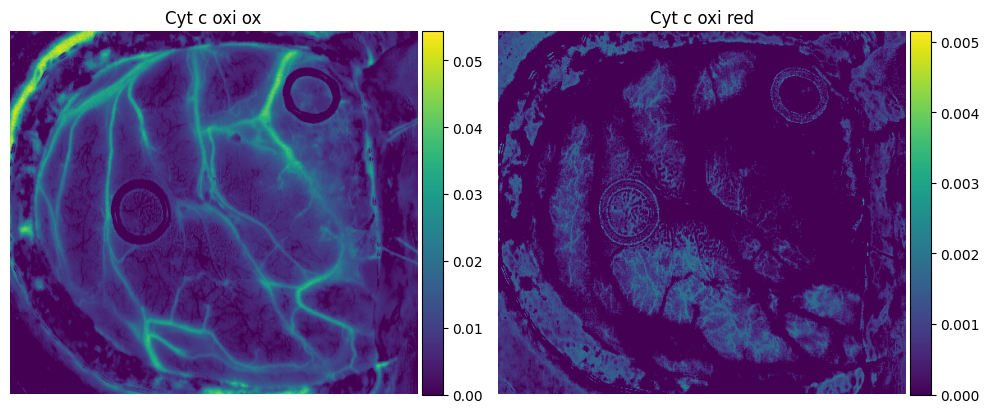

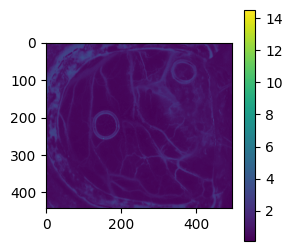

In [26]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones))

endmembers_unmix = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)
for i in tqdm(range(b_simple_img.shape[0])):
    for j in range(b_simple_img.shape[1]):
        scatter_simple = (band_centers/500)**(-b_simple_img[i,j])
        scatter_simple_proj = P @ scatter_simple
        P_scatter = np.eye(M_ones.shape[0]) - np.outer(scatter_simple_proj, scatter_simple_proj) / np.linalg.norm(scatter_simple_proj)**2
        absorbance_proj[i,j,:] = P_scatter @ absorbance_proj[i,j,:]
        M_pixel = P_scatter @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

##### Cytochrome c

Removing Rayleigh scattering

100%|██████████| 443/443 [00:03<00:00, 144.09it/s]


574.484499168838


(<Figure size 300x300 with 2 Axes>, <Axes: >)

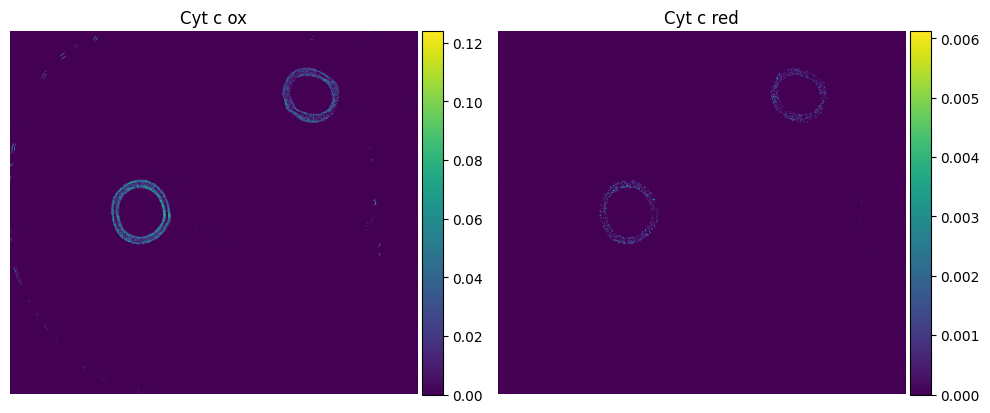

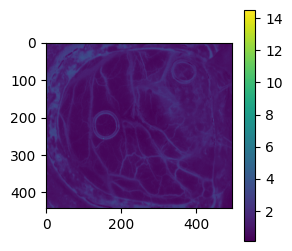

In [27]:
endmembers_proj_cyt_c = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray))
endmembers_unmix_cyt_c = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_cyt_c_proj, endmembers_unmix_cyt_c_proj = project_absorbance(absorbance, endmembers_proj_cyt_c, endmembers_unmix_cyt_c, device="cuda")

M = endmembers_unmix_cyt_c_proj.T
c_cyt_c, err_cyt_c = unmix_LS_nonnegative(M, absorbance_cyt_c_proj)

endmember_labels=["Cyt c ox", "Cyt c red"]
plot_concentrations(c_cyt_c, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_c)

Removing Rayleigh and Mie scattering

100%|██████████| 443/443 [03:20<00:00,  2.21it/s]


539.47437


(<Figure size 300x300 with 2 Axes>, <Axes: >)

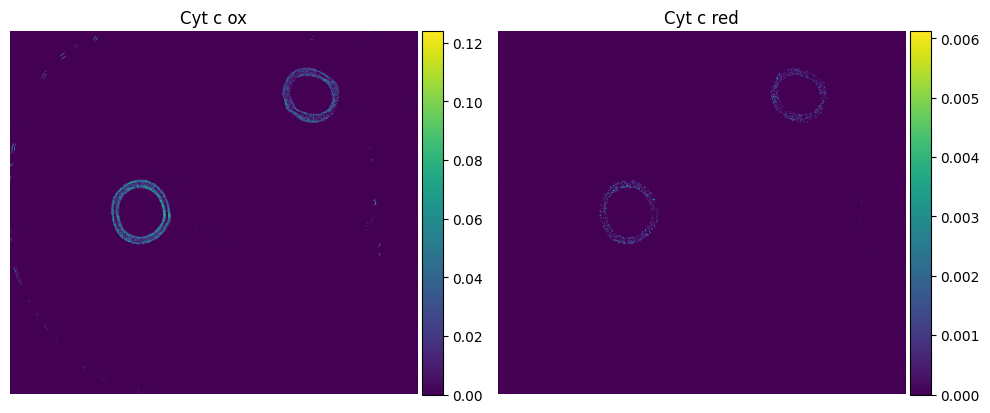

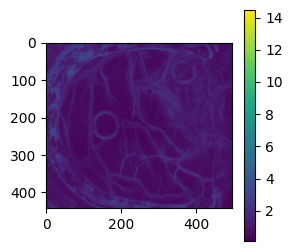

In [28]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray))

endmembers_unmix = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones_scatter.shape[0]) - M_ones_scatter @ np.linalg.pinv(M_ones_scatter)
for i in tqdm(range(b_mie_img.shape[0])):
    for j in range(b_mie_img.shape[1]):
        scatter_mie = (band_centers/500)**(-b_mie_img[i,j])
        scatter_mie_proj = P @ scatter_mie
        P_mie = np.eye(M_ones_scatter.shape[0]) - np.outer(scatter_mie_proj, scatter_mie_proj) / np.linalg.norm(scatter_mie_proj)**2
        absorbance_proj[i,j,:] = P_mie @ absorbance_proj[i,j,:]
        M_pixel = P_mie @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c ox", "Cyt c red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

Removing simplified scattering

100%|██████████| 443/443 [03:28<00:00,  2.13it/s]


585.665


(<Figure size 300x300 with 2 Axes>, <Axes: >)

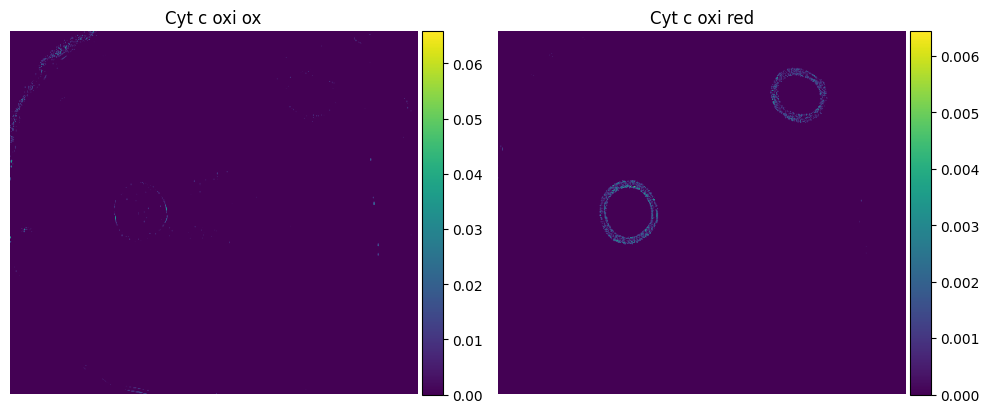

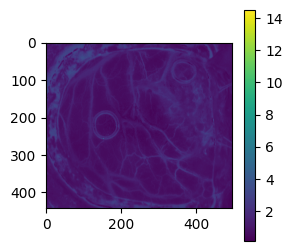

In [29]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones))

endmembers_unmix = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cuda")

c = np.zeros_like(absorbance_proj[:,:,0:2])
sim = np.zeros_like(absorbance_proj[:,:,0])
err = np.zeros_like(absorbance_proj)
P = np.eye(M_ones.shape[0]) - M_ones @ np.linalg.pinv(M_ones)
for i in tqdm(range(b_simple_img.shape[0])):
    for j in range(b_simple_img.shape[1]):
        scatter_simple = (band_centers/500)**(-b_simple_img[i,j])
        scatter_simple_proj = P @ scatter_simple
        P_scatter = np.eye(M_ones.shape[0]) - np.outer(scatter_simple_proj, scatter_simple_proj) / np.linalg.norm(scatter_simple_proj)**2
        absorbance_proj[i,j,:] = P_scatter @ absorbance_proj[i,j,:]
        M_pixel = P_scatter @ endmembers_unmix_proj.T
        c_pixel, err_pixel = unmix_LS_nonnegative(M_pixel, absorbance_proj[i,j,:])
        c[i,j,:] = c_pixel
        err[i,j,:] = err_pixel
        

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c, endmember_labels, figsize=(10,5))

plot_error_img(err)

#### Projection and similarity with Reileigh + estimated Mie scattering removed

In [52]:
# device = "cpu"

# n = M_scatter_smooth.shape[1]
# l, p, k = absorbance.shape
# absorbance_gpu = torch.from_numpy(absorbance).to(device)
# c = torch.zeros(l, p, n).to(device)
# for m in range(n):
#     absorbance_proj = torch.zeros(l,p,k).to(device)
#     M_proj = torch.from_numpy(M_scatter_smooth).to(device)
#     m_extract = M_proj[:,m]
#     for i in tqdm(range(b_mie_img.shape[0])):
#         for j in range(b_mie_img.shape[1]):
#             # Mie scattering for pixel (i,j)
#             scatter_mie = (band_centers/500)**(-b_mie_img[i,j])
#             # replace endmember to be extracted with Mie scattering
#             # M_proj[:,m] = torch.from_numpy(scatter_mie).to(device)
#             # delete culumn m from M_proj
#             M_proj = torch.cat((M_proj[:,:m], M_proj[:,m+1:]), dim=1)

#             # project absorbance and endmember
#             P = torch.eye(M_proj.shape[0], device=device) - M_proj @ torch.linalg.pinv(M_proj)
#             absorbance_proj[i,j,:] = P @ absorbance_gpu[i,j,:]

#             # get similarity to endmember of interest
#             c[i,j,m] = torch.dot(absorbance_proj[i,j,:], m_extract)
#     break   

  0%|          | 0/443 [00:00<?, ?it/s]

100%|██████████| 443/443 [01:06<00:00,  6.61it/s]


In [103]:
# M_proj = M_scatter_smooth.copy()
M_proj = M_smooth.copy()
n = M_proj.shape[1]
l, p, k = absorbance.shape
c = torch.zeros((l, p, n))
for m in range(n):
    absorbance_proj = np.zeros((l,p,k))
    m_extract = M_scatter_smooth[:,m]
    for i in tqdm(range(b_mie_img.shape[0])):
        for j in range(b_mie_img.shape[1]):
            # scattering for pixel (i,j)
            # scatter_mie = (band_centers/500)**(-b_mie_img[i,j])
            # M_proj[:,m] = scatter_mie
            scatter_simple = (band_centers/500)**(-b_simple_img[i,j])
            M_proj[:,m] = scatter_simple
            
            absorbance_proj[i,j,:], _ = project_absorbance(absorbance[i,j,:], M_proj.T, m_extract[None,:], device="cuda")

            # get similarity to endmember of interest
            c[i,j,m] = np.dot(absorbance_proj[i,j,:], m_extract) 

100%|██████████| 443/443 [03:58<00:00,  1.86it/s]


In [111]:
# save c as npy file
# np.save("c_after_mie_proj.npy", c.numpy())
# np.save("c_after_simple_proj.npy", c.numpy())

# load c from npy file
c = torch.from_numpy(np.load("c_after_mie_proj.npy"))
# c = torch.from_numpy(np.load("c_after_simple_proj.npy"))


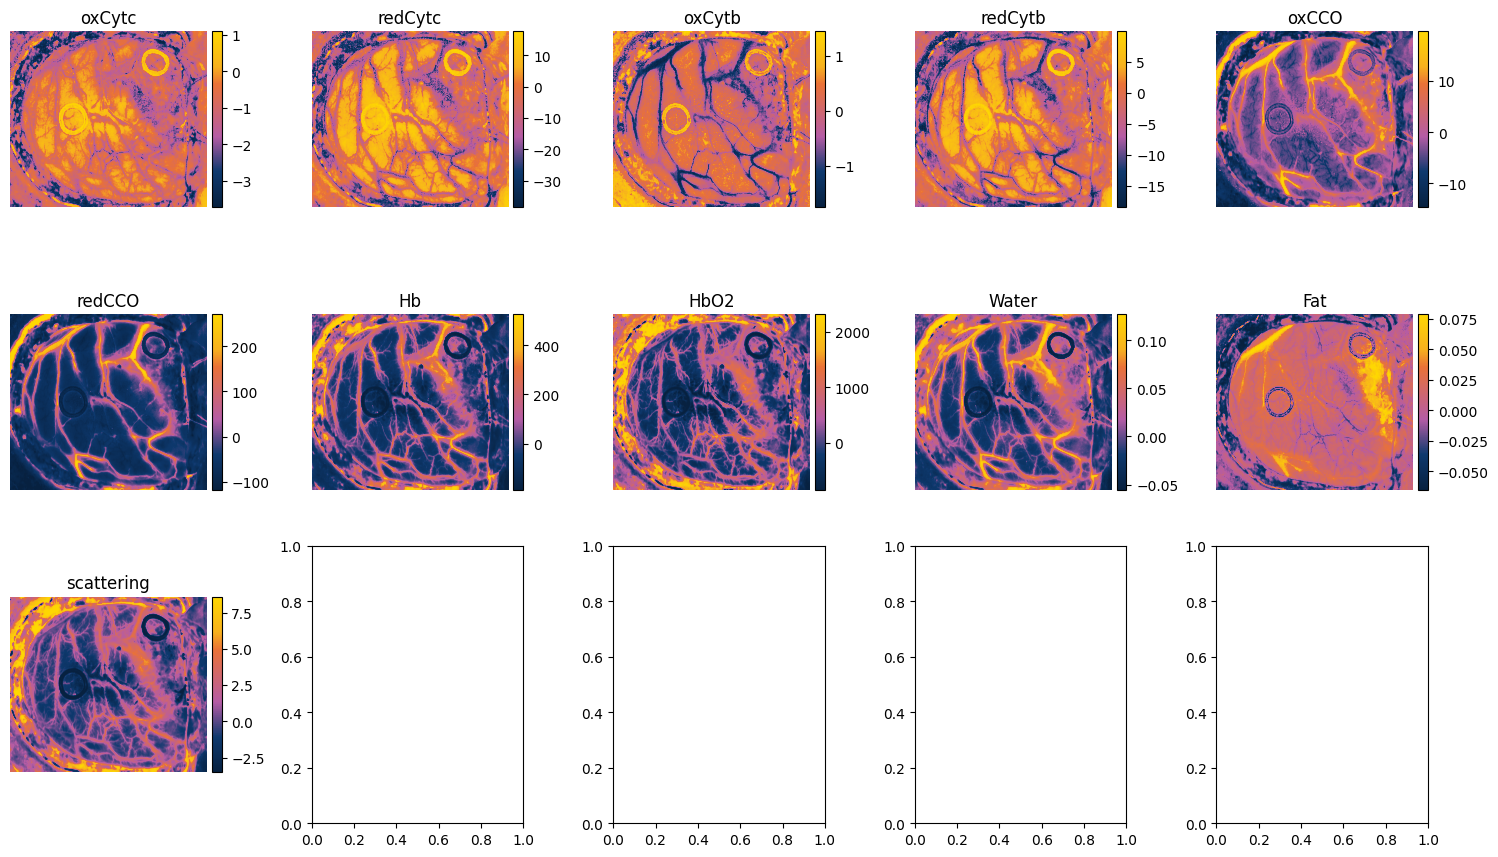

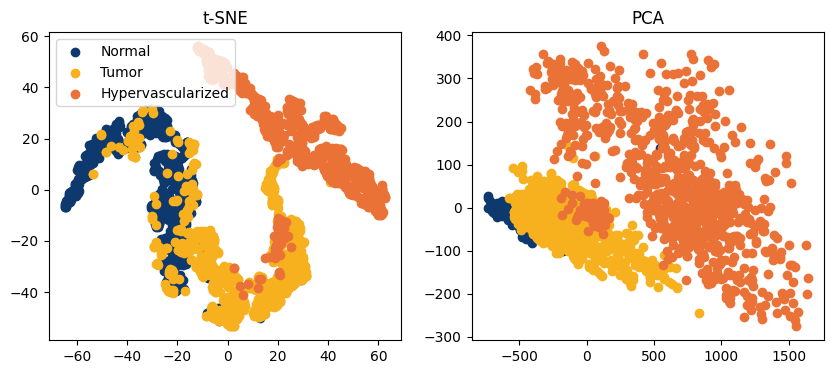

In [112]:
# endmember_labels=["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "Hb", "HbO2", "Water", "Fat", "scattering"]
# plot_concentrations(c, endmember_labels, figsize=(10,5))

endmember_labels=["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "Hb", "HbO2", "Water", "Fat", "scattering"]
# plot_concentrations(c, endmember_labels)


def clip_data(data, lower=1, upper=99):
    lower_clip = np.percentile(data, lower, axis=(0,1), keepdims=True)
    upper_clip = np.percentile(data, upper, axis=(0,1), keepdims=True)
    data = np.clip(data, lower_clip, upper_clip)
    return data

plot_concentrations(clip_data(c), endmember_labels)
plot_pca(clip_data(c), gt_map, class_labels)

(<Figure size 1500x900 with 26 Axes>,
 array([[<Axes: title={'center': 'Cyt c ox'}>,
         <Axes: title={'center': 'Cyt c red'}>,
         <Axes: title={'center': 'Cyt b ox'}>,
         <Axes: title={'center': 'Cyt b red'}>,
         <Axes: title={'center': 'Cyt oxi ox'}>],
        [<Axes: title={'center': 'Cyt oxi red'}>,
         <Axes: title={'center': 'Hb'}>, <Axes: title={'center': 'HbO2'}>,
         <Axes: title={'center': 'Water'}>,
         <Axes: title={'center': 'Fat'}>],
        [<Axes: title={'center': 'scatter'}>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >]], dtype=object))

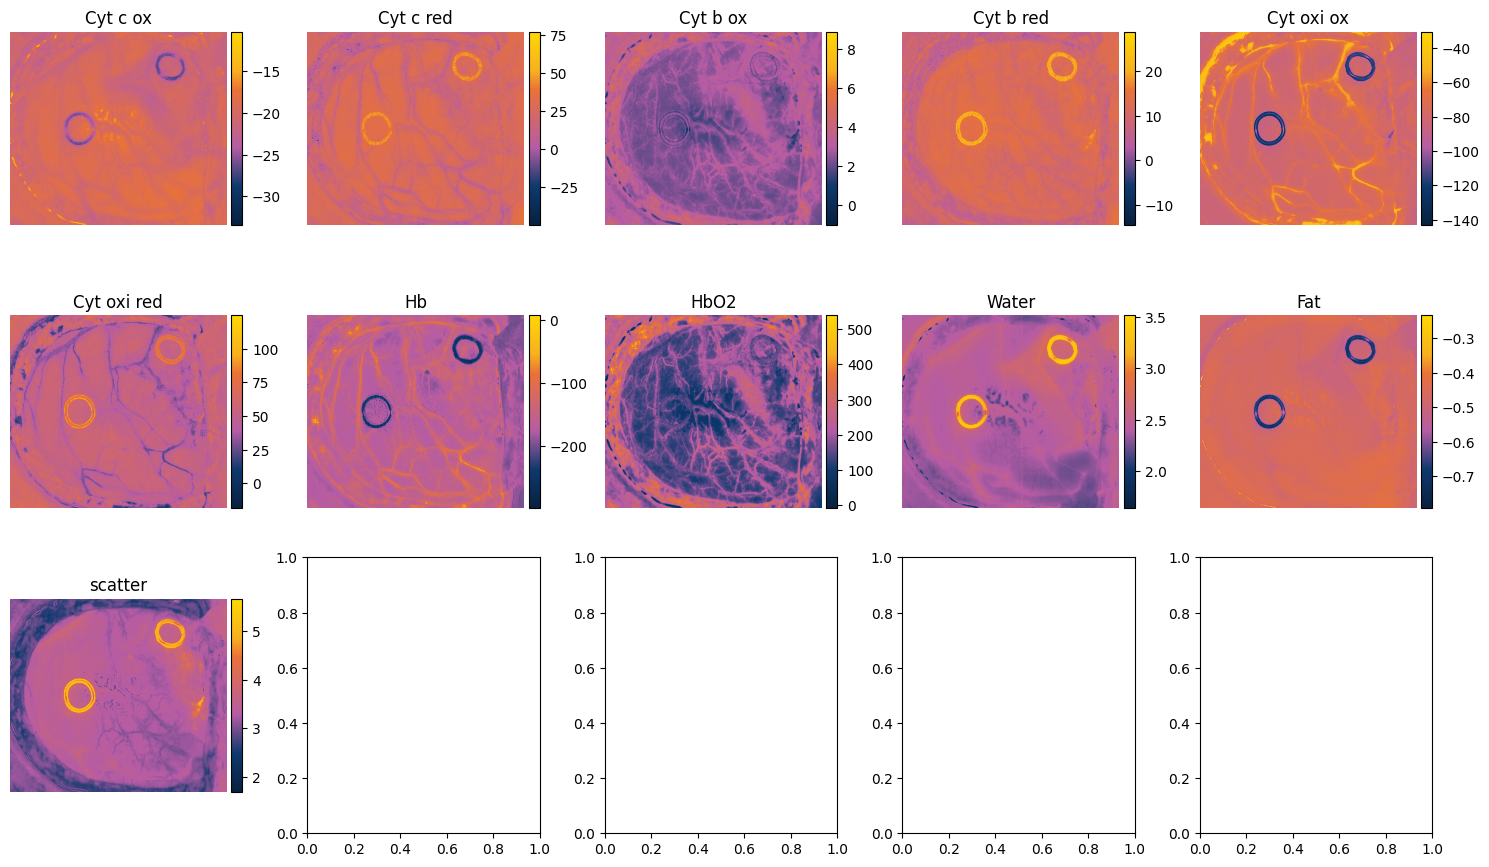

In [64]:
def similarity(abs, spectr):
    return np.einsum("...k,k->...", abs, spectr)

data = np.zeros((absorbance.shape[0],absorbance.shape[1],n))
endmember_array = M_scatter_smooth.T
for i in range(n):
    endmembers_unmix = endmember_array[i,:][None,:]
    endmembers_proj = np.delete(endmember_array, i, axis=0)
    absorbance_proj, endmembers_unmix_proj = project_absorbance(absorbance, endmembers_proj, endmembers_unmix, device="cpu")
    d = similarity(absorbance_proj, endmembers_unmix.squeeze())
    data[:,:,i] = d
plot_concentrations(data, endmember_labels_scatter)